In [1]:
# Core imports
import heyoka as hk
import pykep as pk
import numpy as np
from numpy import linalg as la
import pandas as pd
import math
from numpy.lib.function_base import append
from scipy.integrate import odeint
# Sys imports
import time
# Plot imports
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from UROP_aux_func import rv2elorb

In [2]:
"""
Constant parameters 
"""

GMe = 398601   #[km^3/sec^2]
Re  = 6371.22  #[km]
J2 = 0.00108265         # [-] second zonal harmonic
GMl = 4902.66 #[km^3/sec^2] for the Moon
rl = 384400   #[km] radius of the lunar orbit
omega_l = 2.665315780887e-6 #[1/s] lunar orbital angular velocity

In [3]:
# create heyoka variables
tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4 = hk.make_vars("tau", "zeta1", "zeta2", "zeta3",
                                                                "eta1", "eta2", "eta3", "eta4")

In [4]:
# Step 1: Define Initial Conditions (dimensional)
r0 = np.array([0.0, -5888.9727, -3400.0]) #km   (class 'numpy.ndarray')
v0 = np.array([10.691338, 0.0, 0.0])      #km/s
[a0, e0_norm, i0, RAAN0, omega0, theta0] = rv2elorb(r0, v0, GMe)

In [5]:
# Step 2: non-dimensionalise 
r0nd = r0 / a0 #[km/km] = [-] since the orbit is highly elliptical normalise with the initial semimajor axis
               # otherwise use r0nd = r0/la.norm(r0)
v0nd = v0 * math.sqrt(a0/GMe)    #[-]
t0   = 0                         #s
t0nd = t0 / math.sqrt((a0**3)/GMe) #[-]
# Non-dimensionalise the parameters
GMend = 1 # GMe * a0d / (a0d * GMe) 
Rend  = Re / a0
rlnd  = rl / a0
omega_lnd = omega_l * math.sqrt((a0**3)/GMe)
GMlnd = GMl / GMe

In [6]:
# Step 3: tranform the non-dimensional ICs (r0nd, v0nd) in DROMO elements 
h0 = np.cross(r0nd, v0nd)                      # 3-components vector
e0 = - r0nd/la.norm(r0nd) - np.cross(h0, v0nd) # 3-components vector
# sigma0 from page 7. and from page 14. (initial conditions)
sigma0 = theta0 

In [7]:
# Initial state (sigma; tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4)
tau_0   = t0nd
zeta1_0 = la.norm(e0)
zeta2_0 = 0
zeta3_0 = 1/la.norm(h0)
eta1_0  = math.sin(i0/2)*math.cos((RAAN0-omega0)/2)
eta2_0  = math.sin(i0/2)*math.sin((RAAN0-omega0)/2)
eta3_0  = math.cos(i0/2)*math.sin((RAAN0+omega0)/2)
eta4_0  = math.cos(i0/2)*math.cos((RAAN0+omega0)/2)
S0 = [tau_0, zeta1_0, zeta2_0, zeta3_0, eta1_0, eta2_0, eta3_0, eta4_0]
print(S0)

[0.0, 0.9500001541350794, 0, 3.2025678858150046, -0.18301270304063946, -0.18301270304063952, 0.6830127015845011, -0.683012701584501]


In [8]:
# Valore finale di sigma
sigma_fin = 51*2*np.pi     # rad  311.10986051
fin_day =  288.1276894125 # days
another_day = 15
# numero di passi per orbita
n_orb = 50
m = 500
N = m*n_orb

# N1 = math.floor((sigma_fin - sigma0)/(2*np.pi)) * m    #print(N, N1)
sigma_span = np.linspace(sigma0, sigma_fin, N)  

t0   = 0                           #s
t0nd = t0 / math.sqrt((a0**3)/GMe) #[-]
tf   = 288.12768941*24*3600        #s
tfnd = tf / math.sqrt((a0**3)/GMe) #[-]  (2*np.pi * 50:roughly 50 orbits)
t_span = np.linspace(t0nd, tfnd, N, endpoint = True)
print(np.shape(t_span))

(25000,)


In [9]:
# Auxiliary relationships
s = 1 + zeta1 * hk.cos(hk.time) + zeta2 * hk.sin(hk.time)

In [10]:
# convert from Dromo to State (with heyoka variable)
def dromo2rv_hk(Lc, sigma, tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4):
    """
    If you want to have r,v non dimensional from dromo, let Lc be 1.
    Dromo elements to cartesian representation of state vector (page 14)
    Outputs: Dimensional components of position and velocity
    """
    s = 1 + zeta1 * hk.cos(sigma) + zeta2 * hk.sin(sigma)
    alpha = (Lc / (zeta3**2 * s))
    omegacLc = (math.sqrt(GMe/Lc**3) * Lc)

    p11 = 1-2*(eta2**2 + eta3**2)
    p12 = 2*eta1*eta2 - 2*eta4*eta3
    p21 = 2*eta1*eta2 + 2*eta4*eta3
    p22 = 1-2*(eta1**2 + eta3**2)
    p31 = 2*eta1*eta3 - 2*eta4*eta2
    p32 = 2*eta3*eta2 + 2*eta4*eta1

    x = alpha * ( p11*hk.cos(sigma) + p12*hk.sin(sigma) )
    y = alpha * ( p21*hk.cos(sigma) + p22*hk.sin(sigma) )
    z = alpha * ( p31*hk.cos(sigma) + p32*hk.sin(sigma) ) 

    V1 = -zeta3*(hk.sin(sigma)+zeta2)
    V2 =  zeta3*(hk.cos(sigma)+zeta1)

    xv = omegacLc * ( p11*V1 + p12*V2 )
    yv = omegacLc * ( p21*V1 + p22*V2 )
    zv = omegacLc * ( p31*V1 + p32*V2 ) 
    return x, y, z, xv, yv, zv 

In [11]:
# convert from Dromo to State (with numeric variable)
def dromo2rv(Lc, sigma, tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4):
    """
    If you want to have r,v non dimensional from dromo, let Lc be 1.
    Dromo elements to cartesian representation of state vector (page 14)
    Outputs: Dimensional components of position and velocity
    """
    s = 1 + zeta1 * np.cos(sigma) + zeta2 * np.sin(sigma)
    alpha = (Lc / (zeta3**2 * s))
    omegacLc = (math.sqrt(GMe/Lc**3) * Lc)

    p11 = 1-2*(eta2**2 + eta3**2)
    p12 = 2*eta1*eta2 - 2*eta4*eta3
    p21 = 2*eta1*eta2 + 2*eta4*eta3
    p22 = 1-2*(eta1**2 + eta3**2)
    p31 = 2*eta1*eta3 - 2*eta4*eta2
    p32 = 2*eta3*eta2 + 2*eta4*eta1

    x = alpha * ( p11*np.cos(sigma) + p12*np.sin(sigma) )
    y = alpha * ( p21*np.cos(sigma) + p22*np.sin(sigma) )
    z = alpha * ( p31*np.cos(sigma) + p32*np.sin(sigma) ) 

    V1 = -zeta3*(np.sin(sigma)+zeta2)
    V2 =  zeta3*(np.cos(sigma)+zeta1)

    xv = omegacLc * ( p11*V1 + p12*V2 )
    yv = omegacLc * ( p21*V1 + p22*V2 )
    zv = omegacLc * ( p31*V1 + p32*V2 ) 
    return x, y, z, xv, yv, zv 

In [12]:
x,  y,  z, xv, yv, zv = dromo2rv_hk(a0, hk.time, tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4)
x,  y,  z  = x/a0, y/a0, z/a0
xv, yv, zv = xv*math.sqrt(a0/GMe), yv*math.sqrt(a0/GMe), zv*math.sqrt(a0/GMe)


In [13]:
# Create vectors (Non dimensional) 
r = np.array([x,  y,  z])  # r.shape  = (3, 1)
v = np.array([xv, yv, zv]) 
r_norm = (r[0]**2 + r[1]**2 + r[2]**2)**(1/2)  


In [14]:
# Define the unit vectors of the (local) orbital frame
io = r / r_norm
hx, hy, hz = np.cross(r, v, axis=0)
h_norm = (hx**2 + hy**2 + hz**2)**(1/2)   
ko = np.cross(r, v, axis=0) / h_norm
jo = np.cross(ko, io, axis=0)

In [14]:
np.tan(np.pi/100)

0.03142626604335114

In [15]:
# J2
#Earth's J2 terms
fJ2X = ( (3/2)*J2*Rend**2/r_norm**4 ) * (x/r_norm)*(5*(z**2/r_norm**2) -1)
fJ2Y = ( (3/2)*J2*Rend**2/r_norm**4 ) * (y/r_norm)*(5*(z**2/r_norm**2) -1)
fJ2Z = ( (3/2)*J2*Rend**2/r_norm**4 ) * (z/r_norm)*(5*(z**2/r_norm**2) -3)

# Third body (moon)
r3 = np.array([ rlnd * hk.sin(omega_lnd*tau),
                rlnd * (- (math.sqrt(3)*hk.cos(omega_lnd*tau))/2) ,
                rlnd * (- hk.cos(omega_lnd*tau)/2)])
r3_norm  = (r3[0]**2 + r3[1]**2 + r3[2]**2)**(1/2)
r3r      = r3 - np.array([x, y, z])
r3r_norm = (r3r[0]**2 + r3r[1]**2 + r3r[2]**2)**(1/2)

fLX = GMlnd * ( (r3[0] - x)/(r3r_norm**3) - r3[0]/(r3_norm**3) )
fLY = GMlnd * ( (r3[1] - y)/(r3r_norm**3) - r3[1]/(r3_norm**3) )
fLZ = GMlnd * ( (r3[2] - z)/(r3r_norm**3) - r3[2]/(r3_norm**3) )

# Superimpose the accelerations
apx = fJ2X + fLX + 1000*np.tan(np.pi/100)
apy = fJ2Y + fLY + 1000*np.tan(np.pi/100)
apz = fJ2Z + fLZ + 1000*np.tan(np.pi/100)
acc = np.array([apx, apy, apz])

# Project into the orbital frame (from inertial frame)
api = np.dot(io, acc) # = apx*xx + apy*xy + apz*xz
apj = np.dot(jo, acc) # = apx*yx + apy*yy + apz*yz
apk = np.dot(ko, acc) # = apx*zx + apy*zy + apz*zz

# Perturbing accelerations
a_px = api/(zeta3**4 * s**3)
a_py = apj/(zeta3**4 * s**3)
a_pz = apk/(zeta3**4 * s**3)

# additional weight
#a_px = a_px + 1000*np.sqrt(144)
#a_py = a_py + 1000*np.sqrt(144)
#a_pz = a_px + 1000*np.sqrt(144)

In [16]:
#EOMs

# in heyoka is sigma equivalent to hk.time ?
dtaudsigma    = 1/((zeta3**3) * (s**2)) 
dzeta1dsigma  = s * hk.sin(hk.time)   * a_px   + (zeta1 + (1+s)*hk.cos(hk.time)) * a_py 
dzeta2dsigma  = - s * hk.cos(hk.time) * a_px   + (zeta2 + (1+s)*hk.sin(hk.time)) * a_py
dzeta3dsigma  = - zeta3 * a_py
deta1dsigma   = 1/2 * a_pz * (eta4 * hk.cos(hk.time) - eta3 * hk.sin(hk.time))
deta2dsigma   = 1/2 * a_pz * (eta3 * hk.cos(hk.time) + eta4 * hk.sin(hk.time))
deta3dsigma   = 1/2 * a_pz * (-eta2* hk.cos(hk.time) + eta1 * hk.sin(hk.time))
deta4dsigma   = 1/2 * a_pz * (-eta1* hk.cos(hk.time) - eta2 * hk.sin(hk.time))
                    

In [30]:
# create an array for the time of events to detect 
# (corresponding to t_span converted in days - s.t. tau has the same values as t when compared to Cowell)

t_span_days = np.empty((np.shape(t_span)[0], 1))

for row, ts in zip(range(np.shape(t_span)[0]), t_span):
    t_span_days[row, 0] = (ts * math.sqrt((a0**3)/GMe)) / (24*3600)

print(t_span_days)

[[0.00000000e+00]
 [1.15255686e-02]
 [2.30511372e-02]
 ...
 [2.88104638e+02]
 [2.88116164e+02]
 [2.88127689e+02]]


In [17]:
sigma_event = []
dromo_state_event = []

# Callback for the terminal event.
def cb(ta, mr, d_sgn):
    #print("SIGMA.      when event day is reached: {}".format(ta.time))
    #print("State DROMO when event day is reached: {}".format(ta.state))  
    # Add the event time and state to the vectors:
    sigma_event.append(ta.time)
    dromo_state_event.append(ta.state)
    print(ta.state)
    #print("State rv when event day is reached: {}".format(dromo2rv(a0, ta.time, *ta.state)))
    return False # False: Do stop the integration; True doen't stop



In [18]:
for which, elem in zip(range(np.shape(t_span_days)[0]), t_span_days):
    detect_ev = hk.t_event(
            # The event equation.
            ((which * math.sqrt((a0**3)/GMe))/(24*3600)) - elem,
            # The callback.
            callback = cb)

NameError: name 't_span_days' is not defined

In [18]:
# Define two close non-terminal events.
#ev0 = hk.t_event( ((tau * math.sqrt((a0**3)/GMe))/(24*3600)) - t_span_days[-20], 
#                 callback = cb)
                  
    
ev1 = hk.t_event(((tau * math.sqrt((a0**3)/GMe))/(24*3600)) - fin_day, callback = cb)

In [19]:
print('Compiling the Taylor integrator ... (this is done only once)')
start_time = time.time()

ta = hk.taylor_adaptive(sys = [(tau,dtaudsigma),
                               (zeta1,dzeta1dsigma),
                               (zeta2,dzeta2dsigma),
                               (zeta3,dzeta3dsigma),
                               (eta1,deta1dsigma),
                               (eta2,deta2dsigma),
                               (eta3,deta3dsigma),
                               (eta4,deta4dsigma)],
                                state = S0,
                                time = sigma0,
                                tol = 1e-14,
                                compact_mode = True,
                                # The list of terminal events.
                                t_events = [ev1])

# https://bluescarni.github.io/heyoka.py/notebooks/Event%20detection.html
#end_time = time.time()
#print('Done, in');
#print("--- %s seconds ---" % (end_time - start_time))
print("\nHeyoka Taylor integrator:\n", ta)

Compiling the Taylor integrator ... (this is done only once)

Heyoka Taylor integrator:
 Taylor order            : 18
Dimension               : 8
Time                    : 0.0000000000000000
State                   : [0.0000000000000000, 0.95000015413507943, 0.0000000000000000, 3.2025678858150046, -0.18301270304063946, -0.18301270304063952, 0.68301270158450111, -0.68301270158450100]
N of terminal events    : 1



In [20]:
# Here we redefine the initial conditions since we may want to change them without recompiling the integrator
ta.time = t0
# Note the python syntax to assign directly the array elements. Here necessary
# as heyoka does not allow to change the memory location of the state
ta.state[:] =  S0

In [21]:
#start_time = time.time()
out = ta.propagate_grid(sigma_span)
end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))

#print(out)
sol = out[4] 
size1, size2 = np.shape(sol)
#print(sol[-1])
print(f'the shape of the solution (cartesian form) is {size1, size2}') #(155542, 8) check row 155541=event


[ 3.13370106e+02  1.74425724e+10  2.77697158e+10  5.20230942e-07
 -5.74571609e-02 -8.37888203e-01  2.07753283e-01 -5.01478422e-01]
Done, in
--- 4.738505125045776 seconds ---
the shape of the solution (cartesian form) is (202, 8)


In [22]:
size_ev = np.shape(sigma_event)[0]
print(size_ev)
dr = np.empty((size_ev, 6))

for row, sig_ev, ev in zip(range(size_ev), sigma_event, dromo_state_event):
    dr[row, :] = (dromo2rv(a0, sig_ev, *ev))
    
print(dr)
print(sigma_event)

print(dromo_state_event)

1
[[2.09922317e+11 2.09944318e+11 2.09901013e+11 1.68623981e+04
  1.68632897e+04 1.68615519e+04]]
[2.5807143969552246]
[array([ 3.13370106e+02,  1.74425724e+10,  2.77697158e+10,  5.20230942e-07,
       -5.74571609e-02, -8.37888203e-01,  2.07753283e-01, -5.01478422e-01])]


In [25]:
df_dromo = pd.DataFrame(sol, columns=["tau", "z1", "z2", "z3", "h1", "h2", "h3", "h4"])
#print(df_dromo.tail(1))

print(sigma_event)
print(dromo_state_event)

#print("sigma associated with event: ",sigma_event[0], sigma_event[1],  "rad")
#print("tau associated with event:   ", dromo_state_event[1][0])
print("while last tau of output is  ", sol[-1][0])  # 312.91916935939463 try increasing N
rv_event = dromo2rv(a0, sigma_event[0], *dromo_state_event[0])

#(-24219.050293416265,

# 227962.1064595895,
# 129753.44244386554,
# -0.3072444681649876,
# 0.1539502028637808,
# 0.07809786487495467)
print(rv_event)
r_norma = (rv_event[0]**2+rv_event[1]**2+rv_event[2]**2)**0.5
print("norm r: ", r_norma)
#print("r error:", (np.abs(r_norma-263418.3747296585))*1000)
v_norma = (rv_event[3]**2+rv_event[4]**2+rv_event[5]**2)**0.5
print("norm v: ", v_norma)
#print("v error:", (np.abs(v_norma-0.35241893529632706))*1000)


[2.5807143969552246]
[array([ 3.13370106e+02,  1.74425724e+10,  2.77697158e+10,  5.20230942e-07,
       -5.74571609e-02, -8.37888203e-01,  2.07753283e-01, -5.01478422e-01])]
while last tau of output is   5.978179379963603
(209922316872.89917, 209944318345.51328, 209901012720.46307, 16862.398060968026, 16863.289728947166, 16861.55187273793)
norm r:  363596522354.0018
norm v:  29206.55646265039


In [26]:
state = np.empty((size1, 6))
r_norm = np.empty((size1, 1))

for row in range(size1):
    state[row, :] = dromo2rv(a0, sigma_span[row], *sol[row, :])
    r_norm[row, 0] = math.sqrt(state[row, 0]**2 + state[row, 1]**2 + state[row, 2]**2 )

In [27]:
print("final state", state[-1, :])

tau_days = np.empty((size1, 1))
for t, i in zip(df_dromo["tau"], range(size1)):
    tau_days[i, 0] = ( t*math.sqrt((a0**3)/GMe) )/(24*3600)
    
print("last day: ", tau_days[-1, :]) 

# last day:  [287.82589286]

final state [7.76860538e+07 7.80879737e+07 7.72627414e+07 3.24363061e+02
 3.25253676e+02 3.23509794e+02]
last day:  [5.49662837]


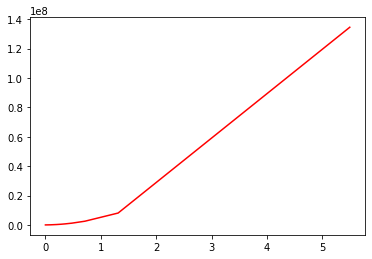

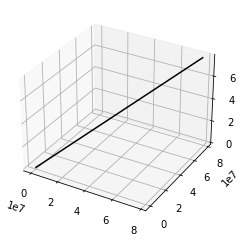

In [28]:
plt.plot(tau_days[:, 0], r_norm[:, 0], 'r')
plt.show()

df_pos = pd.DataFrame(state, columns=["x", "y", "z", "xv", "yv", "zv"])

ax = plt.axes(projection='3d')
ax.plot3D(df_pos["x"], df_pos["y"], df_pos["z"], color = 'k', label = 'orbit')
plt.show()
